<a href="https://colab.research.google.com/github/kbdev20/Thesis/blob/main/yolov5s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
In this Google Colab notebook, we explore a comparison of Convolutional Neural Network (CNN) models specifically designed for object detection in vehicular environments using dashcam images. The primary models of interest are the YOLO (You Only Look Once) variants from Ultralytics. Our key focus areas include evaluating these models based on their accuracy, time consumption during prediction, and resource consumption.

#Loading Ultralytics YOLO Model
In this cell, we're importing the YOLO library from Ultralytics and loading a pre-trained YOLOv5 model from ultralytics using its associated weight file 'yolov5s.pt'. This prepares the model for subsequent prediction tasks.

In [1]:
!pip install ultralytics

In [2]:
from ultralytics import YOLO  # Import the Ultralytics YOLO library
model = YOLO('yolov5s.pt')     # Load a pre-trained YOLOv8 model


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



---

#Data Loading and Preparation

In this cell, we have a function `LoadImagesAndLabels` which loads and processes images and their corresponding labels from the specified paths. After defining this utility function, we've set paths to our test data and then used the function to load the dataset into appropriate variables.

In [3]:
import os
import cv2
import torch
from pathlib import Path

def LoadImagesAndLabels(img_path, label_path):
    img_files = sorted([img_path/f for f in os.listdir(img_path) if f.endswith('.jpg') or f.endswith('.png')])
    label_files = sorted([label_path/f for f in os.listdir(label_path) if f.endswith('.txt')])
    images = []
    dataset = []
    for img_file, label_file in zip(img_files, label_files):
        # Load image
        img = cv2.imread(str(img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Load labels
        with open(label_file, 'r') as file:
            labels = file.read().strip().split('\n')
            labels = [list(map(float, label.split())) for label in labels]
            labels = torch.tensor(labels, dtype=torch.float32)  # Convert to tensor

        dataset.append((img, labels))
        images.append(img)
    return dataset, images


# Define the path to your test data
img_path = Path('/content/drive/MyDrive/szakdoga/dashcamdatav1yoloformat/train/images')
label_path = Path('/content/drive/MyDrive/szakdoga/dashcamdatav1yoloformat/train/labels')

# Load the dataset
dataset, images = LoadImagesAndLabels(img_path, label_path)

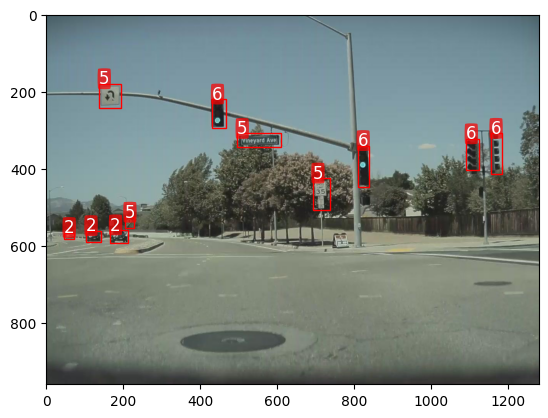

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch


# Example data
image, labels = dataset[3]

# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Loop over the labels tensor and add a rectangle for each one
for label in labels:
    # Extract individual labels
    class_id, x, y, w, h = label

    # Because the coordinates are normalized to [0, 1], we need to multiply them
    # by the image's width and height to scale them back up.
    img_height, img_width = image.shape[:2]

    # Compute the rectangle's coordinates
    x = x * img_width
    y = y * img_height
    w = w * img_width
    h = h * img_height

    # Create a rectangle patch
    rect = patches.Rectangle((x - w/2, y - h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Add the class label text
    plt.text(x - w/2, y - h/2, str(int(class_id.item())), fontsize=12, color='white',
             bbox=dict(facecolor='red', edgecolor='none', boxstyle='round4,pad=0.1', alpha=0.7))

# Show the plot
plt.show()


#Model Execution and Performance Timing

In this section:

1. **Timing Predictions**:
    - We're running the YOLO model on each image in our test dataset.
    - We measure the prediction time for each image and store it in a list, `times`.
    - Additionally, Ultralytics YOLO provides more granular timing details, which are stored in `times2`.

2. **Summary Statistics**:
    - We compute the total and average prediction time across all test images.

3. **Visualization**:
    - Using matplotlib, we plot the time taken for preprocessing, inference, and postprocessing for each image. This gives a clear visual representation of where the model spends most of its time during the prediction process for each image.


In [5]:
import time
import torch
import numpy as np

def measure_time(model, dataset, device):
    model = model.to(device)
    times = []
    times2 = []

    start_total = time.time()
    for i in range(3):
        for img, labels in dataset:
            #img = img.to(device)
            start = time.time()
            results = model(img)  # Ensure this works with your model
            end = time.time()
            times2.append(results[0].speed)
            times.append(end - start)
    end_total = time.time() - start_total

    total_time = sum(times[1:])  # Excluding the first measurement
    avg_time = np.mean(times[1:])  # Excluding the first measurement

    return times[1:], times2[1:], total_time, avg_time

# Example usage
device_gpu = torch.device("cuda:0")
device_cpu = torch.device("cpu")
times_gpu, times2_gpu, total_time_gpu, avg_time_gpu = measure_time(model, dataset, device_gpu)
times_cpu, times2_cpu, total_time_cpu, avg_time_cpu = measure_time(model, dataset, device_cpu)





0: 480x640 2 cars, 4 traffic lights, 68.7ms
Speed: 3.4ms preprocess, 68.7ms inference, 94.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 3 traffic lights, 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 5 traffic lights, 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 truck, 5 traffic lights, 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 2 traffic lights, 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 

yolo time object

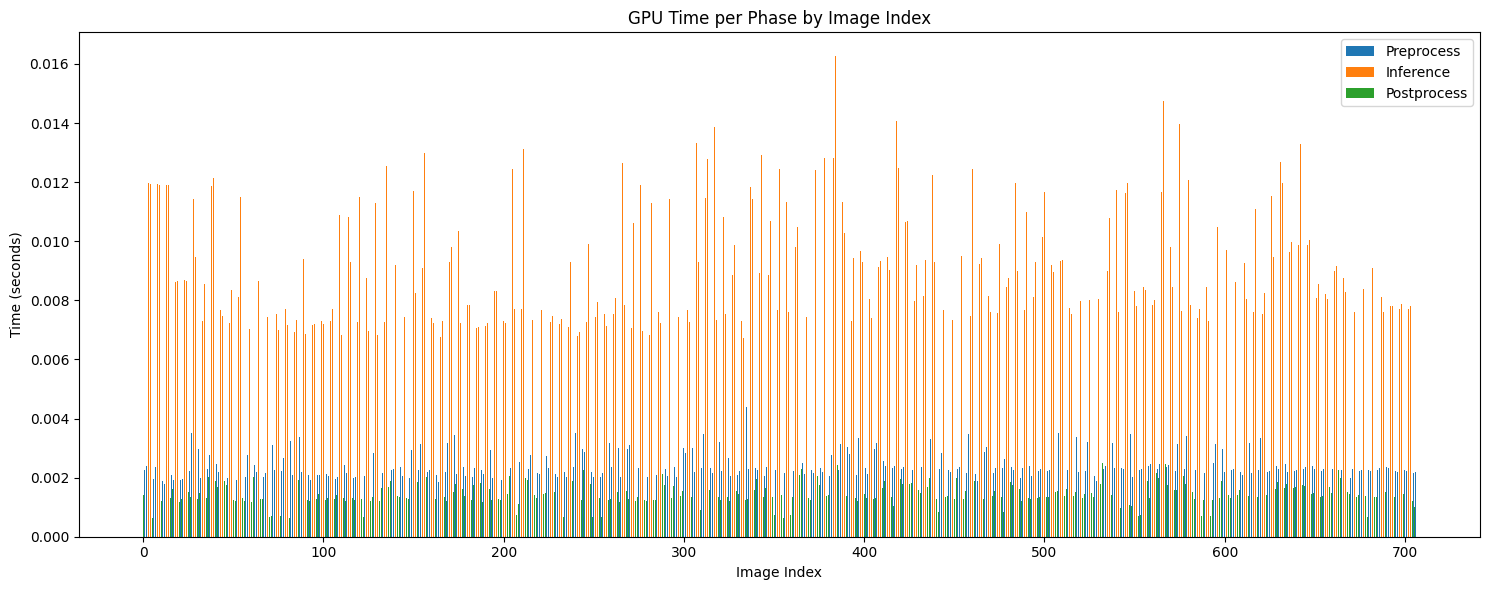

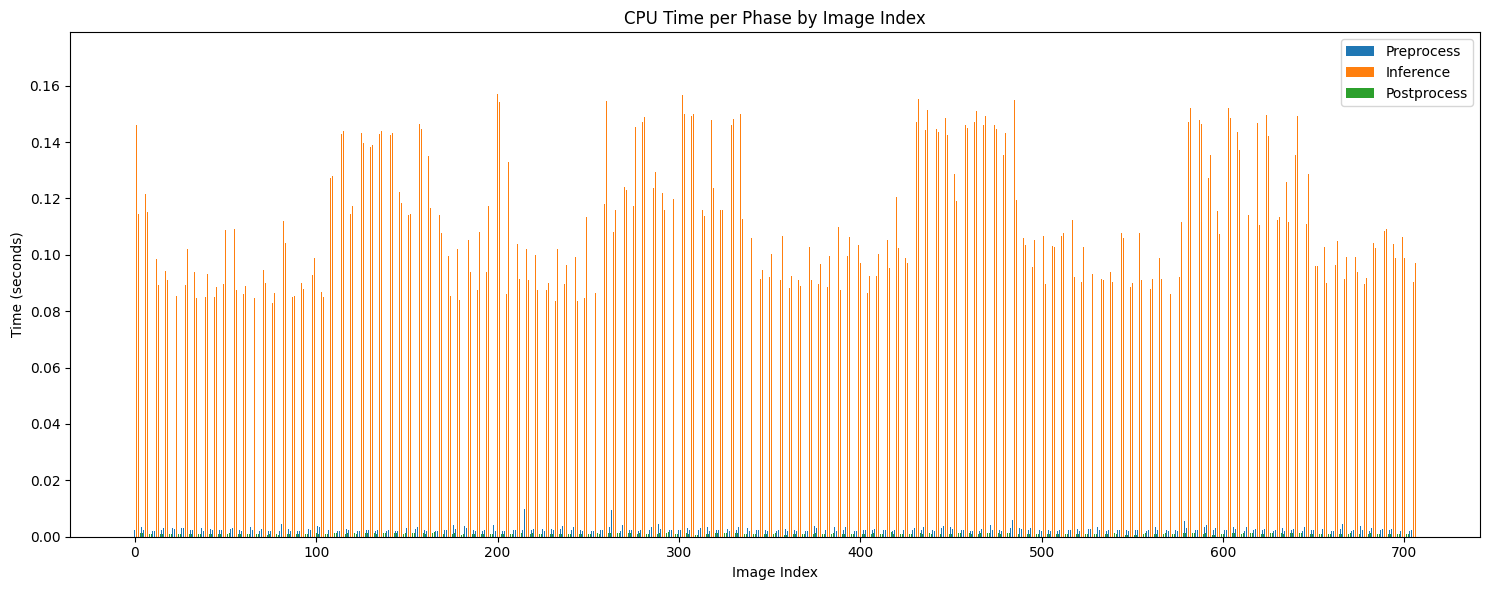

In [6]:
def plot_gpu_yolo_type(times2, type):
    # Convert milliseconds to seconds
    preprocess_times = np.array([time['preprocess'] / 1000 for time in times2])
    inference_times = np.array([time['inference'] / 1000 for time in times2])
    postprocess_times = np.array([time['postprocess'] / 1000 for time in times2])

    ind = np.arange(len(times2))
    fig, ax = plt.subplots(figsize=(15, 6))  # Adjusted for a wider plot
    bar_width = 0.2

    ax.bar(ind - bar_width, preprocess_times, bar_width, label='Preprocess')
    ax.bar(ind, inference_times, bar_width, label='Inference')
    ax.bar(ind + bar_width, postprocess_times, bar_width, label='Postprocess')

    ax.set_xlabel('Image Index')
    ax.set_ylabel('Time (seconds)')
    ax.set_title(type + ' Time per Phase by Image Index')
    ax.set_xticks(ind[::100])  # Set x-ticks every 100
    ax.set_xticklabels([str(i) for i in ind[::100]])  # Label every 100
    ax.legend()

    fig.tight_layout()
    plt.show()

# usage
plot_gpu_yolo_type(times2_gpu, "GPU")
plot_gpu_yolo_type(times2_cpu, "CPU")



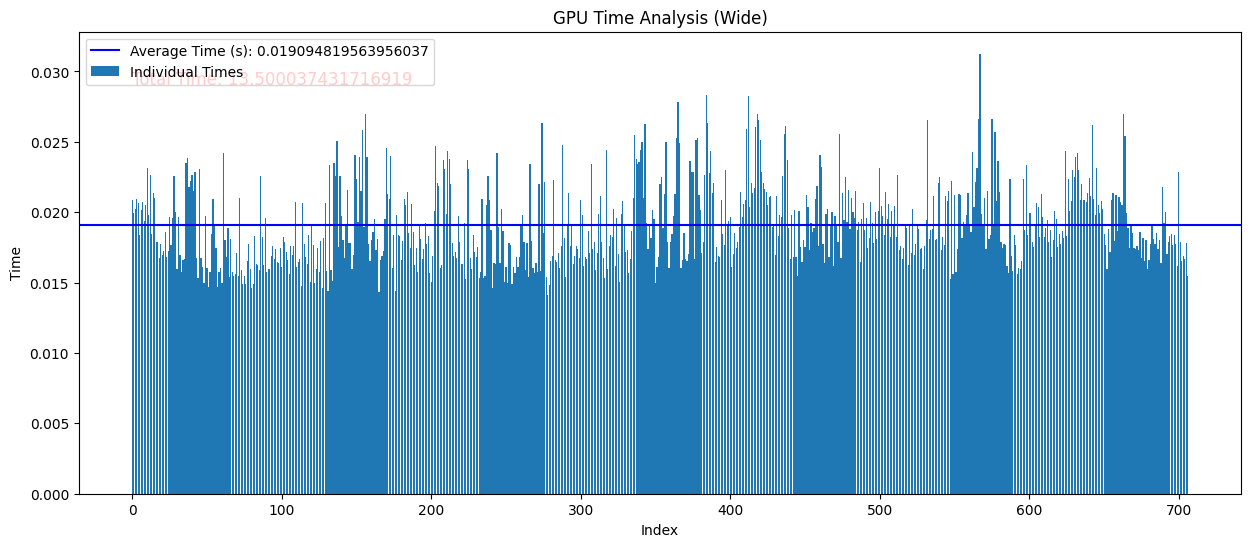

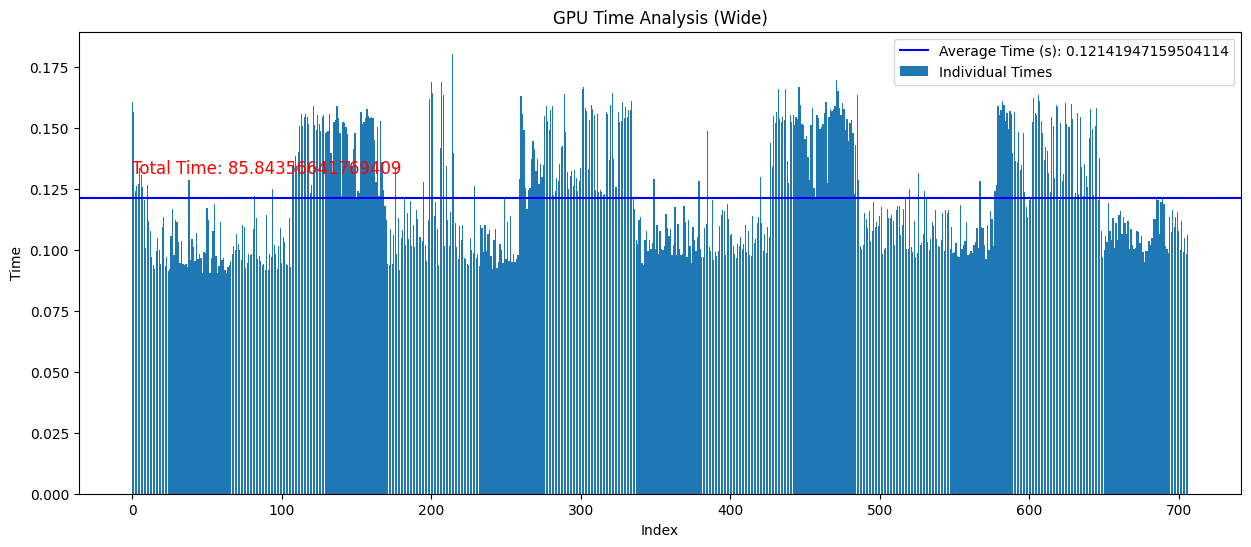

In [7]:
def plot_gpu_second_type(times, total_time, avg_time):
    fig, ax = plt.subplots(figsize=(15, 6))  # Adjusted for a wider plot

    ax.bar(range(len(times)), times, label='Individual Times')
    ax.axhline(y=avg_time, color="b", linestyle="-", label=f"Average Time (s): {avg_time}")
    ax.text(0, avg_time + 0.01, f'Total Time: {total_time}', color='r', fontsize=12)

    ax.set_xlabel('Index')
    ax.set_ylabel('Time')
    ax.set_title('GPU Time Analysis (Wide)')
    ax.legend()

    ax.set_xticks(range(0, len(times), 100))  # Set x-ticks every 100
    ax.set_xticklabels([str(i) for i in range(0, len(times), 100)])  # Label every 100

    plt.show()

plot_gpu_second_type(times_gpu, total_time_gpu, avg_time_gpu)
plot_gpu_second_type(times_cpu, total_time_cpu, avg_time_cpu)


###Resource Consumption Analysis
A crucial aspect of evaluating model performance is understanding its resource consumption. This entails observing how the model utilizes available computing resources, primarily GPU and CPU, during its execution. Proper monitoring can help in optimizations and making informed decisions about deployment. This segment will break down the resource usage for both GPU and CPU while executing the model on the dataset.

#GPU Resource Consumption
Summary:
In the GPU segment, we focus on tracking the GPU's utilization and memory usage while the model processes the dataset. Using the NVIDIA System Management Interface (nvidia-smi) and the PyNVML library, we can query the GPU's health metrics. These metrics are essential to understand how efficiently our model uses GPU resources and to pinpoint any potential bottlenecks or issues.

First, we install and display GPU stats using gpustat and nvidia-smi.
Next, we define a utility function get_gpu_resource_usage that returns the current GPU utilization and memory usage.
The model is transferred to the GPU using PyTorch's .to(device) method.
During the execution of each image through the model, we record the GPU's resource metrics.
Finally, these metrics are visualized to show the GPU's usage and memory consumption over time.

In [8]:
!pip install gpustat

In [9]:
import subprocess
import re

def get_gpu_utilization():
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader'],
                                text=True, capture_output=True, check=True)
        utilization_strs = result.stdout.strip().split('\n')
        # Parse the utilization percentages from the output
        utilization = []
        for util_str in utilization_strs:
            match = re.search(r'(\d+)\s*%', util_str)
            if match:
                utilization.append(int(match.group(1)))
            else:
                print(f'Warning: Could not parse utilization from string: {util_str}')
        return utilization
    except subprocess.CalledProcessError as e:
        print(f'Error: {e.output}')
        return None
    except FileNotFoundError:
        print('Error: nvidia-smi not found. Is an NVIDIA driver installed?')
        return None




In [10]:

!nvidia-smi



Sun Nov 26 20:03:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    30W /  70W |    429MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
import pynvml as nvml
import torch

gpu_usage = []
gpu_mem_usage = []

def get_gpu_resource_usage():
    nvml.nvmlInit()
    handle = nvml.nvmlDeviceGetHandleByIndex(0)
    gpu_utilization = nvml.nvmlDeviceGetUtilizationRates(handle).gpu
    gpu_memory_info = nvml.nvmlDeviceGetMemoryInfo(handle).used / (1024**2)  # Convert to MB
    nvml.nvmlShutdown()

    return gpu_utilization, gpu_memory_info

# Record initial GPU resource usage
initial_gpu, initial_gpu_mem = get_gpu_resource_usage()

device = torch.device("cuda:0")
model = model.to(device)

# Run the model on each image in the test dataset
for img, labels in dataset:
    gpu, gpu_mem = get_gpu_resource_usage()

    results = model(img)

    gpu_usage.append(gpu)
    gpu_mem_usage.append(gpu_mem)

    print(f'GPU Utilization: {gpu}%')
    print(f'GPU Memory Usage: {gpu_mem:.2f} MB')

# Record final GPU resource usage
final_gpu, final_gpu_mem = get_gpu_resource_usage()

# Output the final GPU resource consumption
print(f'Final GPU Utilization: {final_gpu}%')
print(f'Final GPU Memory Usage: {final_gpu_mem:.2f} MB')





0: 480x640 2 cars, 4 traffic lights, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
GPU Utilization: 0%
GPU Memory Usage: 687.19 MB

0: 480x640 3 cars, 3 traffic lights, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
GPU Utilization: 0%
GPU Memory Usage: 687.19 MB

0: 480x640 2 cars, 5 traffic lights, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
GPU Utilization: 0%
GPU Memory Usage: 687.19 MB

0: 480x640 1 car, 1 truck, 5 traffic lights, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
GPU Utilization: 0%
GPU Memory Usage: 687.19 MB

0: 480x640 5 cars, 2 traffic lights, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
GPU Utilization: 0%
GPU Memory Usage: 687.19 MB

0: 480x640 2 cars, 11.8ms
Speed: 2.0ms pr

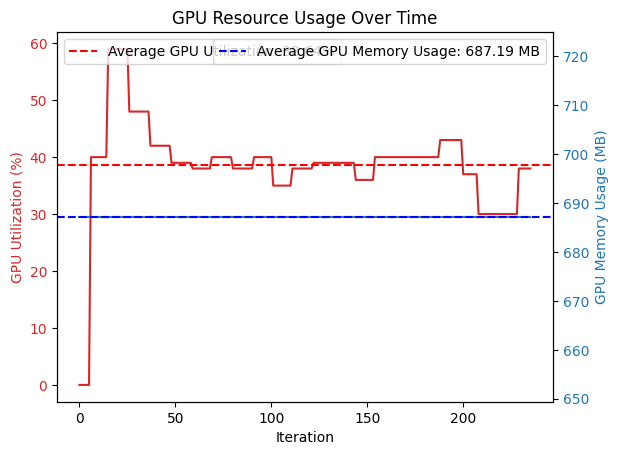

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# plot the data
fig, ax1 = plt.subplots()

# Plot GPU Utilization
color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('GPU Utilization (%)', color=color)
ax1.plot(gpu_usage, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('GPU Memory Usage (MB)', color=color)
ax2.plot(gpu_mem_usage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Calculate and plot the averages
avg_gpu = np.mean(gpu_usage)
avg_gpu_mem = np.mean(gpu_mem_usage)
ax1.axhline(y=avg_gpu, color='red', linestyle='--', label=f'Average GPU Utilization: {avg_gpu:.2f}%')
ax2.axhline(y=avg_gpu_mem, color='blue', linestyle='--', label=f'Average GPU Memory Usage: {avg_gpu_mem:.2f} MB')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.title('GPU Resource Usage Over Time')
plt.show()


#CPU Resource Consumption
Summary:
The CPU resource analysis tracks the CPU's utilization and the system's memory usage as the model processes the dataset on the CPU. For this, we make use of the psutil library, which provides an interface to retrieve information on system utilization.

We define a utility function get_resource_usage that returns the current CPU usage percentage and used memory.
The model is shifted to the CPU.
As the model processes each image, we capture the CPU's usage and system memory metrics.
At the end, these metrics are plotted to visualize the CPU's usage and system memory consumption during the model's execution.
By the conclusion of this segment, we have a clearer understanding of the model's behavior in terms of resource consumption, which can guide optimization efforts and deployment considerations.

In [13]:
import psutil
import time

cpu_usage = []
mem_usage = []

def get_resource_usage():
    cpu_usage = psutil.cpu_percent(interval=1)  # Get CPU usage percentage, averaged over 1 second
    memory_usage = psutil.virtual_memory().used  # Get the used memory in bytes
    return cpu_usage, memory_usage

# Record initial resource usage
initial_cpu, initial_mem = get_resource_usage()



device = torch.device("cpu")
print(model.device)
model = model.to(device)
print(model.device)
# Run the model on each image in the test dataset
for i in range(3):
  for img, labels in dataset:
      cpu, mem = get_resource_usage()
      results = model(img)
      mem_usage.append(mem)
      cpu_usage.append(cpu)
      print((mem)/ (1024 ** 2) , "MB")
      print(f'CPU Usage: {cpu}%')

# Record final resource usage
final_cpu, final_mem = get_resource_usage()

# Calculate the difference in resource usage
cpu_usage_diff = final_cpu
mem_usage_diff = final_mem

# Output the resource consumption
print(f'CPU Usage: {cpu_usage_diff}%')
print(f'Memory Usage: {mem_usage_diff / (1024 ** 2):.2f} MB')  # Convert bytes to megabytes



cuda:0
cpu

0: 480x640 2 cars, 4 traffic lights, 154.2ms
Speed: 2.6ms preprocess, 154.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
2519.47265625 MB
CPU Usage: 13.9%

0: 480x640 3 cars, 3 traffic lights, 135.6ms
Speed: 2.6ms preprocess, 135.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
2541.55859375 MB
CPU Usage: 16.5%

0: 480x640 2 cars, 5 traffic lights, 137.0ms
Speed: 2.5ms preprocess, 137.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
2564.7109375 MB
CPU Usage: 18.8%

0: 480x640 1 car, 1 truck, 5 traffic lights, 145.1ms
Speed: 2.6ms preprocess, 145.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
2578.8203125 MB
CPU Usage: 14.1%

0: 480x640 5 cars, 2 traffic lights, 145.6ms
Speed: 2.5ms preprocess, 145.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
2578.03125 MB
CPU Usage: 27.4%

0: 480x640 2 cars, 154.1ms
Speed: 6.3ms preprocess, 154.1ms inference, 1.3ms postprocess per im

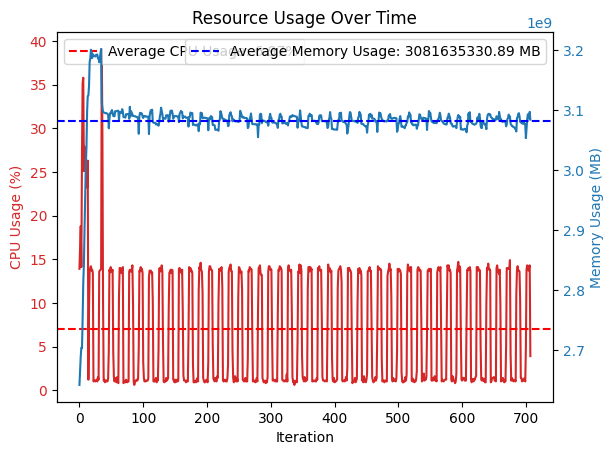

In [14]:
# plot the data
fig, ax1 = plt.subplots()

# Plot CPU usage
color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('CPU Usage (%)', color=color)
ax1.plot(cpu_usage, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Memory Usage (MB)', color=color)
ax2.plot(mem_usage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Calculate and plot the averages
avg_cpu = np.mean(cpu_usage)
avg_mem = np.mean(mem_usage)
ax1.axhline(y=avg_cpu, color='red', linestyle='--', label=f'Average CPU Usage: {avg_cpu:.2f}%')
ax2.axhline(y=avg_mem, color='blue', linestyle='--', label=f'Average Memory Usage: {avg_mem:.2f} MB')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.title('Resource Usage Over Time')
plt.show()


In [15]:
!pip install wandb

In [17]:
torch.cuda.is_available()


True

# Model Evaluation and Visualization
This code is for evaluating an object detection model, focusing on prediction accuracy and visualization. It involves data preprocessing, prediction analysis, and visual representation of model performance.

Code Breakdown:
1. Data Preparation
Import necessary libraries.
Generate predictions and corresponding labels from the model.
2. Label and Prediction Processing
Flatten and reformat labels and predictions for analysis.
3. IoU Calculation
Implement a function to calculate the Intersection Over Union (IoU) between bounding boxes.
4. Matching and Analyzing Boxes
Match predicted boxes with true boxes and analyze overlaps.
5. Visualization of Boxes
Visualize true and predicted boxes on images.
6. Bounding Box Labeling
Draw bounding boxes and class names on images, and correct class labels.
7. Class Label Filtering
Filter and correct class labels for evaluation.
8. Evaluation Metrics
Compute accuracy, precision, recall, F1-Score, and mean IoU.
9. Metrics Visualization
Plot confusion matrix and IoU histogram.
10. Model Benchmarking
Benchmark the model using Ultralytics tools.

## Data Preparation: Sets up the environment and prepares the dataset for prediction using the model.

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

In [19]:
predictions = []
test_labels = []
for img, labels in dataset:
    results = model(img)
    predictions.append(results)
    test_labels.append(labels)



0: 480x640 2 cars, 4 traffic lights, 110.0ms
Speed: 2.7ms preprocess, 110.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 3 traffic lights, 84.5ms
Speed: 2.4ms preprocess, 84.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 5 traffic lights, 88.5ms
Speed: 2.3ms preprocess, 88.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 1 truck, 5 traffic lights, 86.7ms
Speed: 2.3ms preprocess, 86.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 2 traffic lights, 100.3ms
Speed: 2.5ms preprocess, 100.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 86.0ms
Speed: 2.3ms preprocess, 86.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 91.8ms
Speed: 2.2ms preprocess, 91.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person,

In [20]:
results = model(images)

#test_labels[0]


0: 480x640 2 cars, 4 traffic lights, 1: 480x640 3 cars, 3 traffic lights, 2: 480x640 2 cars, 5 traffic lights, 3: 480x640 1 car, 1 truck, 5 traffic lights, 4: 480x640 5 cars, 2 traffic lights, 5: 480x640 2 cars, 6: 480x640 (no detections), 7: 480x640 1 person, 1 car, 8: 480x640 2 persons, 9: 480x640 1 person, 10: 480x640 3 cars, 1 truck, 11: 480x640 7 cars, 1 bus, 1 truck, 3 traffic lights, 12: 480x640 3 cars, 1 bus, 1 truck, 4 traffic lights, 13: 480x640 4 cars, 1 truck, 14: 480x640 (no detections), 15: 480x640 4 cars, 1 truck, 5 traffic lights, 16: 480x640 2 cars, 5 traffic lights, 17: 480x640 1 person, 1 car, 18: 480x640 2 cars, 1 bench, 19: 480x640 (no detections), 20: 480x640 3 cars, 21: 480x640 5 cars, 22: 480x640 5 cars, 1 traffic light, 23: 480x640 7 cars, 1 bus, 4 traffic lights, 24: 480x640 8 cars, 5 traffic lights, 25: 480x640 9 cars, 1 truck, 6 traffic lights, 26: 480x640 8 cars, 6 traffic lights, 27: 480x640 5 cars, 5 traffic lights, 28: 480x640 7 cars, 5 traffic lights, 

## Label and Prediction Processing: Converts model outputs into a structured format for easy analysis.

In [21]:
flattened_labels = []
for image_idx, tensor in enumerate(test_labels):  # Assuming test_labels is a list of tensors
    if isinstance(tensor, torch.Tensor):  # Check if tensor is a torch.Tensor
        if tensor.dim() == 2 and tensor.size(1) == 5:  # Check if tensor has correct dimensions
            for i in range(tensor.size(0)):  # Iterate over rows in tensor
                row = tensor[i]
                class_label, x, y, width, height = row
                flattened_labels.append({
                    'image_id': image_idx,
                    'class': int(class_label.item()),
                    'bbox': [float(coord.item()) for coord in [x, y, width, height]]
                })
        else:
          flattened_labels.append({
                    'image_id': image_idx,
                    'class': -1,
                    'bbox': -1
                })


# Now flattened_labels is a list of dictionaries, each containing an image ID, class label, and bounding box coordinates



for i in flattened_labels:
  print(i)




{'image_id': 0, 'class': 6, 'bbox': [0.15906250476837158, 0.21595832705497742, 0.025648437440395355, 0.06679166853427887]}
{'image_id': 0, 'class': 6, 'bbox': [0.9070390462875366, 0.324072927236557, 0.042781248688697815, 0.13831250369548798]}
{'image_id': 0, 'class': 6, 'bbox': [0.14031249284744263, 0.32623958587646484, 0.014421874657273293, 0.03967708349227905]}
{'image_id': 0, 'class': 6, 'bbox': [0.32111719250679016, 0.35335415601730347, 0.015367187559604645, 0.03696874901652336]}
{'image_id': 0, 'class': 5, 'bbox': [0.3581562638282776, 0.38888540863990784, 0.04067187383770943, 0.017937500029802322]}
{'image_id': 0, 'class': 6, 'bbox': [0.45851561427116394, 0.421875, 0.02071874961256981, 0.06308333575725555]}
{'image_id': 0, 'class': 5, 'bbox': [0.4146796762943268, 0.4560208320617676, 0.021593749523162842, 0.04803124815225601]}
{'image_id': 0, 'class': 2, 'bbox': [0.048828125, 0.5311041474342346, 0.024257812649011612, 0.019239583984017372]}
{'image_id': 1, 'class': 5, 'bbox': [0.161

In [22]:
for i in range(len(results)):
  print(results[i].boxes.cls)
print(results[24].probs)
for result in results:
  print(result.probs)

tensor([9., 9., 9., 2., 9., 2.])
tensor([2., 9., 9., 2., 9., 2.])
tensor([9., 9., 2., 9., 9., 2., 9.])
tensor([9., 9., 9., 9., 2., 9., 7.])
tensor([9., 9., 2., 2., 2., 2., 2.])
tensor([2., 2.])
tensor([])
tensor([0., 2.])
tensor([0., 0.])
tensor([0.])
tensor([2., 2., 7., 2.])
tensor([2., 2., 9., 5., 7., 2., 9., 9., 2., 2., 2., 2.])
tensor([9., 2., 9., 9., 9., 2., 5., 7., 2.])
tensor([2., 7., 2., 2., 2.])
tensor([])
tensor([9., 2., 9., 7., 9., 9., 2., 9., 2., 2.])
tensor([2., 9., 9., 9., 9., 9., 2.])
tensor([0., 2.])
tensor([ 2.,  2., 13.])
tensor([])
tensor([2., 2., 2.])
tensor([2., 2., 2., 2., 2.])
tensor([2., 2., 9., 2., 2., 2.])
tensor([2., 9., 2., 2., 2., 9., 9., 2., 5., 9., 2., 2.])
tensor([9., 2., 2., 9., 2., 2., 9., 2., 2., 2., 9., 2., 9.])
tensor([2., 2., 2., 2., 2., 2., 7., 9., 2., 9., 9., 9., 2., 9., 2., 9.])
tensor([2., 9., 2., 9., 9., 2., 2., 2., 9., 2., 2., 9., 9., 2.])
tensor([9., 9., 9., 2., 2., 2., 9., 9., 2., 2.])
tensor([2., 9., 9., 2., 2., 9., 2., 9., 9., 2., 2., 2.]

In [23]:
flattened_predictions = []
for image_idx, result in enumerate(results):  # Assuming results is iterable and has a similar structure to test_labels
  for bbox in result.boxes:
    entry = {
      'image_id': image_idx,
      'class': int(bbox.cls.tolist()[0]),
      'bbox': bbox.xywhn.tolist()[0]
    }
    flattened_predictions.append(entry)
print(flattened_predictions)
len(flattened_predictions)
len(flattened_labels)

[{'image_id': 0, 'class': 9, 'bbox': [0.907325267791748, 0.31915777921676636, 0.028887558728456497, 0.12760113179683685]}, {'image_id': 0, 'class': 9, 'bbox': [0.1391712725162506, 0.3274277150630951, 0.013568282127380371, 0.0387890487909317]}, {'image_id': 0, 'class': 9, 'bbox': [0.15884311497211456, 0.21704667806625366, 0.023108625784516335, 0.0656927078962326]}, {'image_id': 0, 'class': 2, 'bbox': [0.2602066099643707, 0.5255904197692871, 0.03475189208984375, 0.01716887205839157]}, {'image_id': 0, 'class': 9, 'bbox': [0.32042065262794495, 0.3517870604991913, 0.014768886379897594, 0.0426761619746685]}, {'image_id': 0, 'class': 2, 'bbox': [0.04876410961151123, 0.5293465256690979, 0.025346696376800537, 0.0210418701171875]}, {'image_id': 1, 'class': 2, 'bbox': [0.9786888360977173, 0.49585068225860596, 0.04195861890912056, 0.043947093188762665]}, {'image_id': 1, 'class': 9, 'bbox': [0.06670080125331879, 0.2954697906970978, 0.01590096950531006, 0.047366268932819366]}, {'image_id': 1, 'class

1812

In [24]:
#for result in results:
#  print(result)
for result in flattened_predictions:
  print(result)

{'image_id': 0, 'class': 9, 'bbox': [0.907325267791748, 0.31915777921676636, 0.028887558728456497, 0.12760113179683685]}
{'image_id': 0, 'class': 9, 'bbox': [0.1391712725162506, 0.3274277150630951, 0.013568282127380371, 0.0387890487909317]}
{'image_id': 0, 'class': 9, 'bbox': [0.15884311497211456, 0.21704667806625366, 0.023108625784516335, 0.0656927078962326]}
{'image_id': 0, 'class': 2, 'bbox': [0.2602066099643707, 0.5255904197692871, 0.03475189208984375, 0.01716887205839157]}
{'image_id': 0, 'class': 9, 'bbox': [0.32042065262794495, 0.3517870604991913, 0.014768886379897594, 0.0426761619746685]}
{'image_id': 0, 'class': 2, 'bbox': [0.04876410961151123, 0.5293465256690979, 0.025346696376800537, 0.0210418701171875]}
{'image_id': 1, 'class': 2, 'bbox': [0.9786888360977173, 0.49585068225860596, 0.04195861890912056, 0.043947093188762665]}
{'image_id': 1, 'class': 9, 'bbox': [0.06670080125331879, 0.2954697906970978, 0.01590096950531006, 0.047366268932819366]}
{'image_id': 1, 'class': 9, 'bb

## IoU Calculation: A crucial step in object detection that assesses how well the predicted bounding boxes align with the ground truth.

In [25]:
def calculate_iou(boxA, boxB):
    # Error checking
    if not (isinstance(boxA, (list, tuple)) and isinstance(boxB, (list, tuple))):
        print("Error: boxA or boxB is not a list or tuple.")
        return 0
    if len(boxA) != 4 or len(boxB) != 4:
        print(f"Error: boxA or boxB does not have 4 elements. boxA: {boxA}, boxB: {boxB}")
        return 0

    # Convert to top-left and bottom-right coordinates
    boxA = [boxA[0] - boxA[2]/2, boxA[1] - boxA[3]/2, boxA[2], boxA[3]]
    boxB = [boxB[0] - boxB[2]/2, boxB[1] - boxB[3]/2, boxB[2], boxB[3]]

    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou



def match_boxes(truelist, predictedlist, epsilon):
    matched_pairs = []
    used_predicted = set()  # To track which predicted boxes have been matched
    bboxID = 0  # Initialize bboxID counter

    placeholder = {'image_id': -1, 'class': -1, 'bbox': [-1, -1, -1, -1], 'bboxID': -1, 'truebox': -1}

    # First, try to match each true box with a predicted box
    for true_box in truelist:
        max_iou = 0
        matched_box = None

        for idx, predicted_box in enumerate(predictedlist):
            if true_box['image_id'] == predicted_box['image_id']:
                iou = calculate_iou(true_box['bbox'], predicted_box['bbox'])
                if iou > max_iou and iou > epsilon:
                    max_iou = iou
                    matched_box = predicted_box
                    matched_idx = idx

        if matched_box is not None:
            true_box['bboxID'] = bboxID
            matched_box['bboxID'] = bboxID
            true_box['truebox'] = True
            matched_box['truebox'] = False

            matched_pairs.append((true_box, matched_box))
            used_predicted.add(matched_idx)  # Mark this predicted box as used
            bboxID += 1  # Increment bboxID for the next matched pair
        else:
            matched_pairs.append((true_box, placeholder.copy()))  # Add a placeholder for false negatives

    # Add any unmatched predicted boxes as false positives
    for idx, predicted_box in enumerate(predictedlist):
        if idx not in used_predicted:
            predicted_box['bboxID'] = bboxID
            predicted_box['truebox'] = False
            matched_pairs.append((placeholder.copy(), predicted_box))  # Add a placeholder for false positives
            bboxID += 1

    return matched_pairs




## Matching and Analyzing Boxes: Identifies correct and incorrect predictions by comparing the ground truth with the model's outputs.

In [26]:

matched_pairs = match_boxes(flattened_labels,flattened_predictions, 0.5)

print(len(matched_pairs))
print(matched_pairs)


Error: boxA or boxB is not a list or tuple.
2110
[({'image_id': 0, 'class': 6, 'bbox': [0.15906250476837158, 0.21595832705497742, 0.025648437440395355, 0.06679166853427887], 'bboxID': 0, 'truebox': True}, {'image_id': 0, 'class': 9, 'bbox': [0.15884311497211456, 0.21704667806625366, 0.023108625784516335, 0.0656927078962326], 'bboxID': 0, 'truebox': False}), ({'image_id': 0, 'class': 6, 'bbox': [0.9070390462875366, 0.324072927236557, 0.042781248688697815, 0.13831250369548798], 'bboxID': 1, 'truebox': True}, {'image_id': 0, 'class': 9, 'bbox': [0.907325267791748, 0.31915777921676636, 0.028887558728456497, 0.12760113179683685], 'bboxID': 1, 'truebox': False}), ({'image_id': 0, 'class': 6, 'bbox': [0.14031249284744263, 0.32623958587646484, 0.014421874657273293, 0.03967708349227905], 'bboxID': 2, 'truebox': True}, {'image_id': 0, 'class': 9, 'bbox': [0.1391712725162506, 0.3274277150630951, 0.013568282127380371, 0.0387890487909317], 'bboxID': 2, 'truebox': False}), ({'image_id': 0, 'class': 

## Visualization of Boxes: Offers a visual representation of the model's prediction accuracy on individual images.

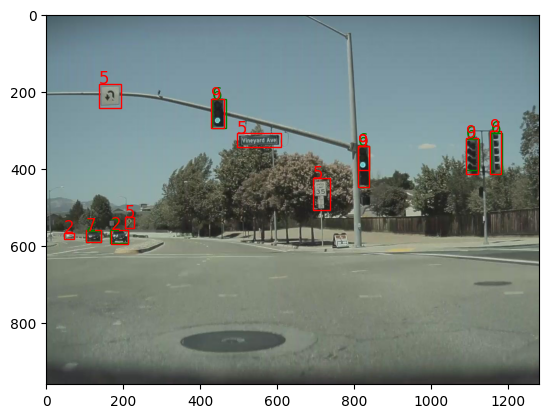

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to plot a single image with bounding boxes
def plot_boxes(image, matched_pairs):
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Get the image dimensions
    img_height, img_width = image.shape[:2]

    # Plot each bounding box
    for pair in matched_pairs:
        for box in pair:
            if box and 'bbox' in box and box['bbox'] != [-1, -1, -1, -1]:
                # Get the details of the bounding box
                x_center, y_center, width, height = box['bbox']

                # Convert normalized coordinates to pixel coordinates
                x_center = x_center * img_width
                y_center = y_center * img_height
                width = width * img_width
                height = height * img_height

                # Calculate the top-left corner coordinates
                x = x_center - width / 2
                y = y_center - height / 2

                # Check if 'truebox' key exists and choose the color based on its value
                color = 'g' if 'truebox' in box and box['truebox'] else 'r'

                # Create a Rectangle patch
                rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor=color, facecolor='none')

                # Add the patch to the Axes
                ax.add_patch(rect)

                # Annotate the class label, if class is not None
                if 'class' in box and box['class'] is not None:
                    plt.text(x, y, str(box['class']), color=color, fontsize=12)

    plt.show()

# Example usage
# Assuming 'images' and 'matched_pairs' are already defined
image_id = 3  # Change this to choose which image to plot
matched_pairs_for_image = [pair for pair in matched_pairs if (pair[0] is not None and pair[0]['image_id'] == image_id) or (pair[1] is not None and pair[1]['image_id'] == image_id)]
plot_boxes(images[image_id], matched_pairs_for_image)


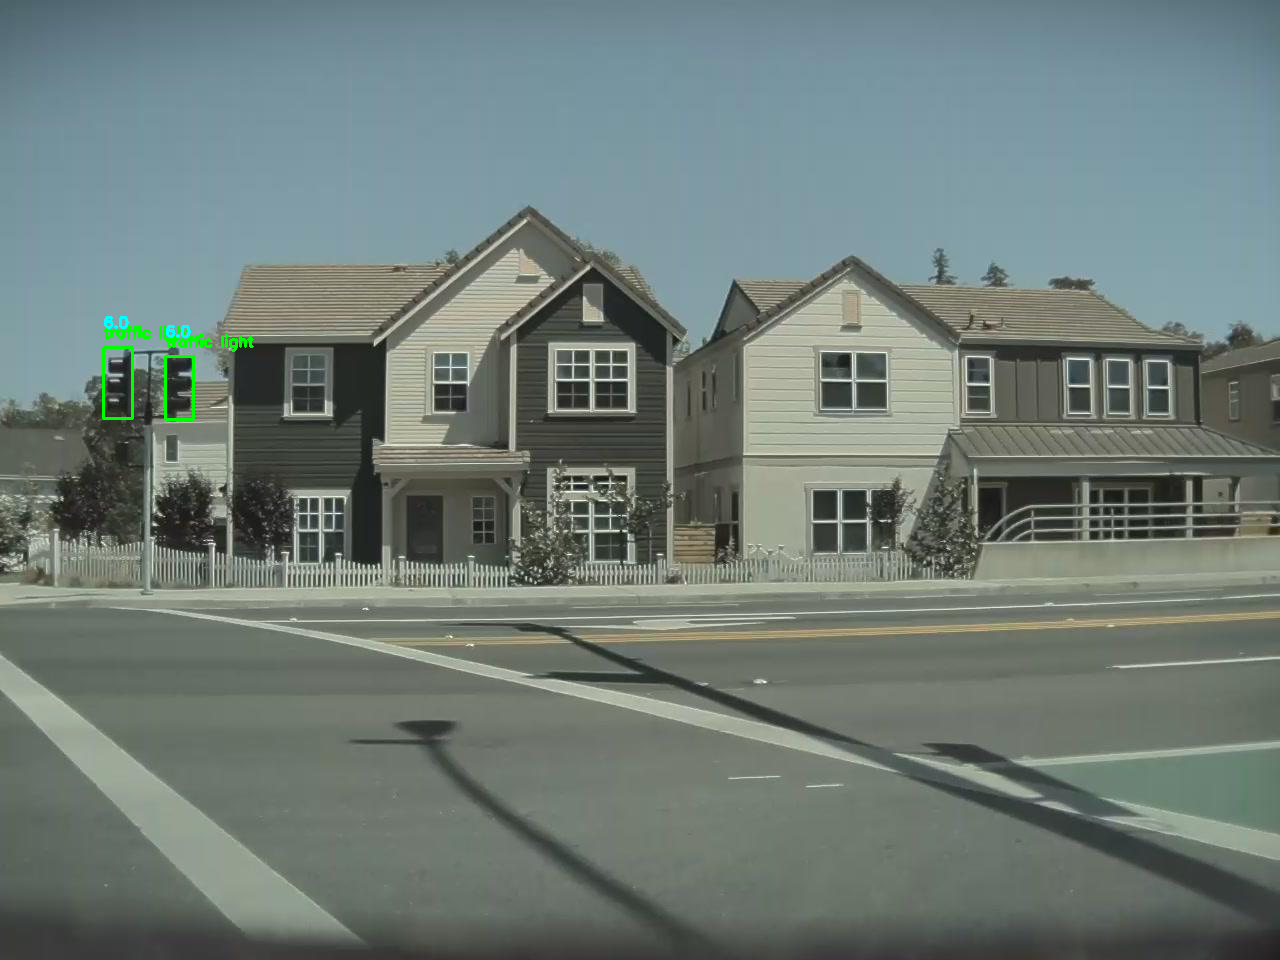

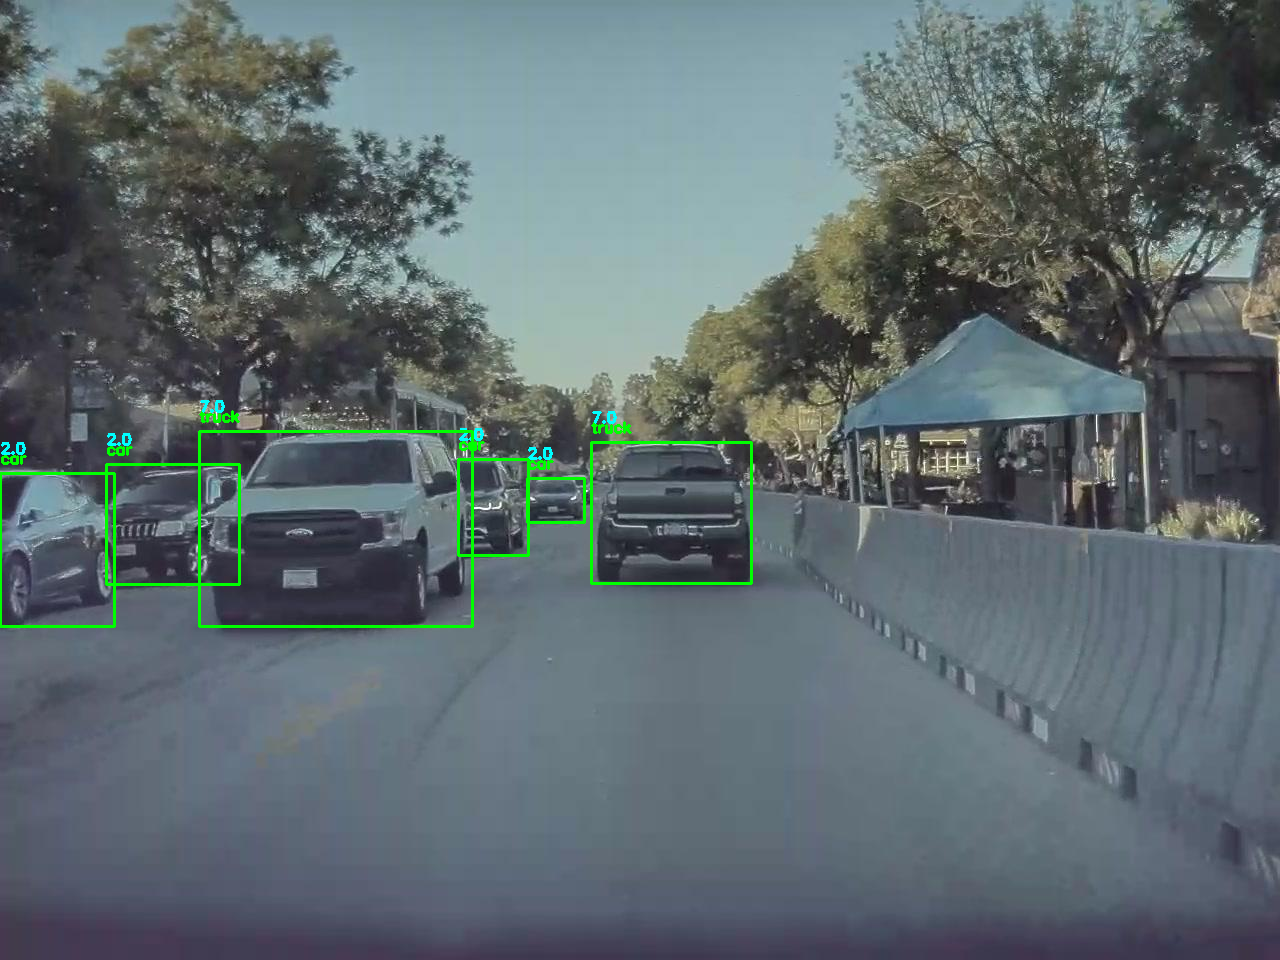

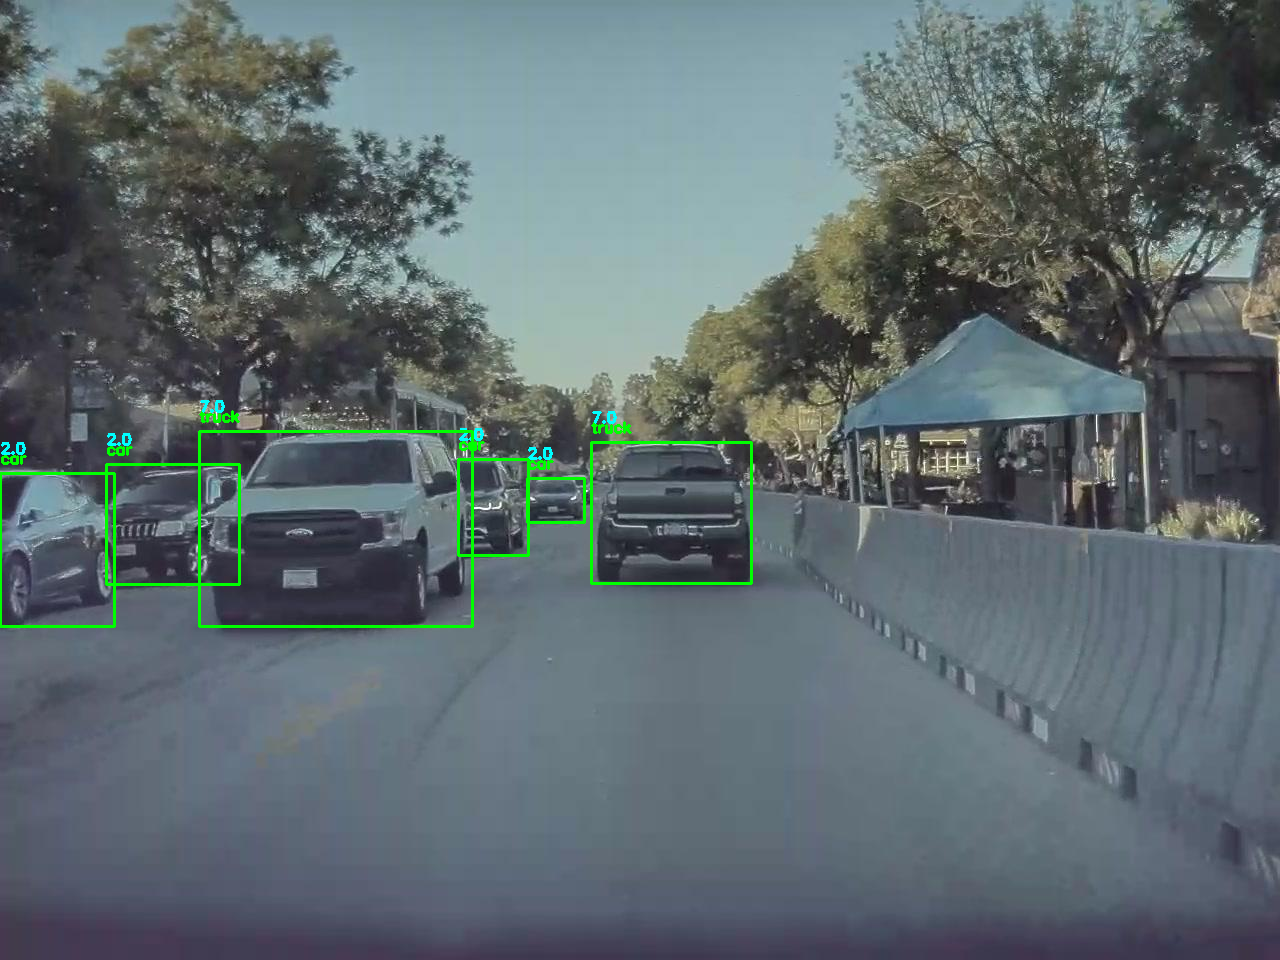

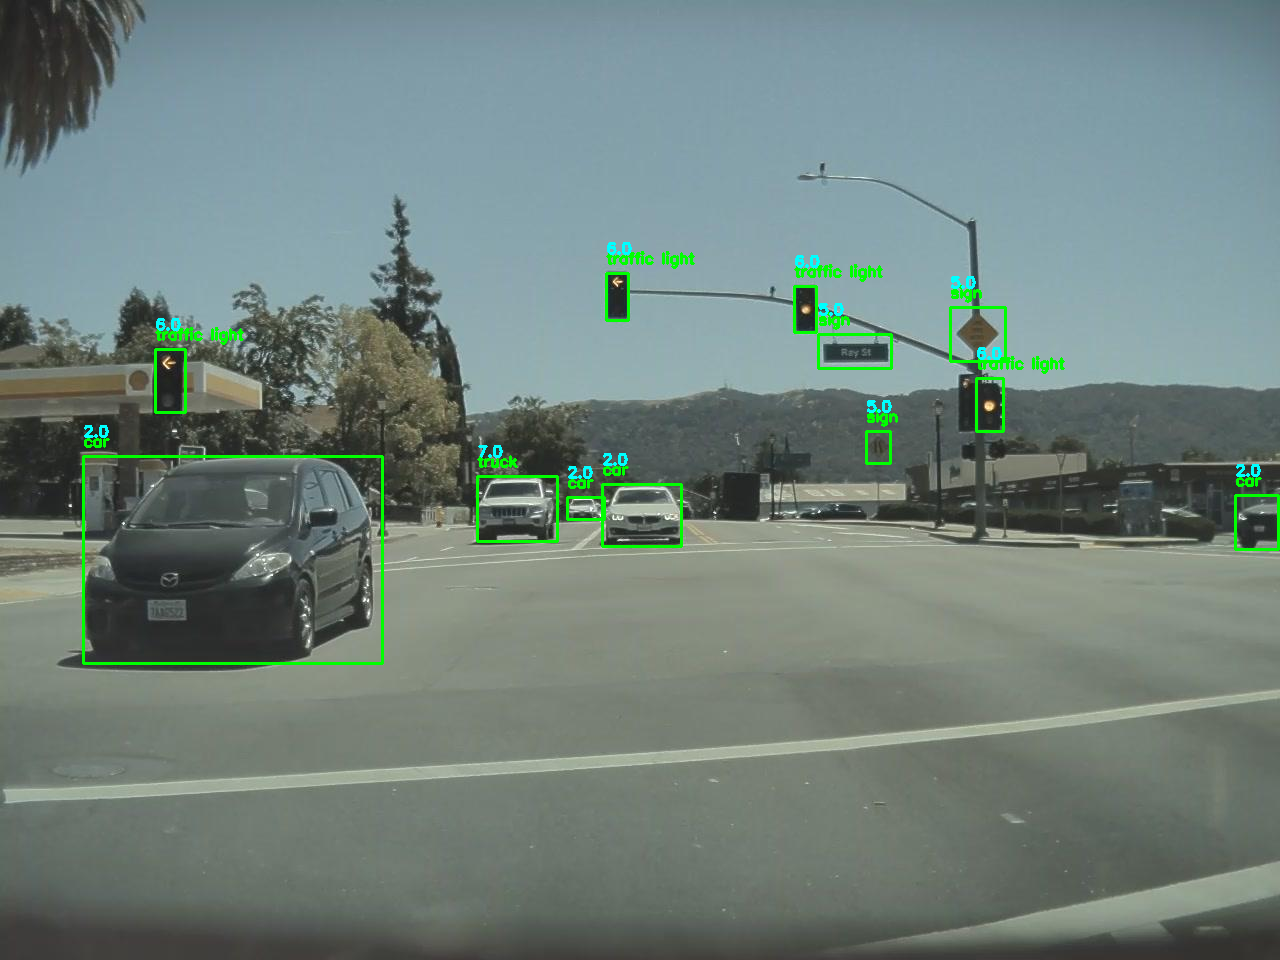

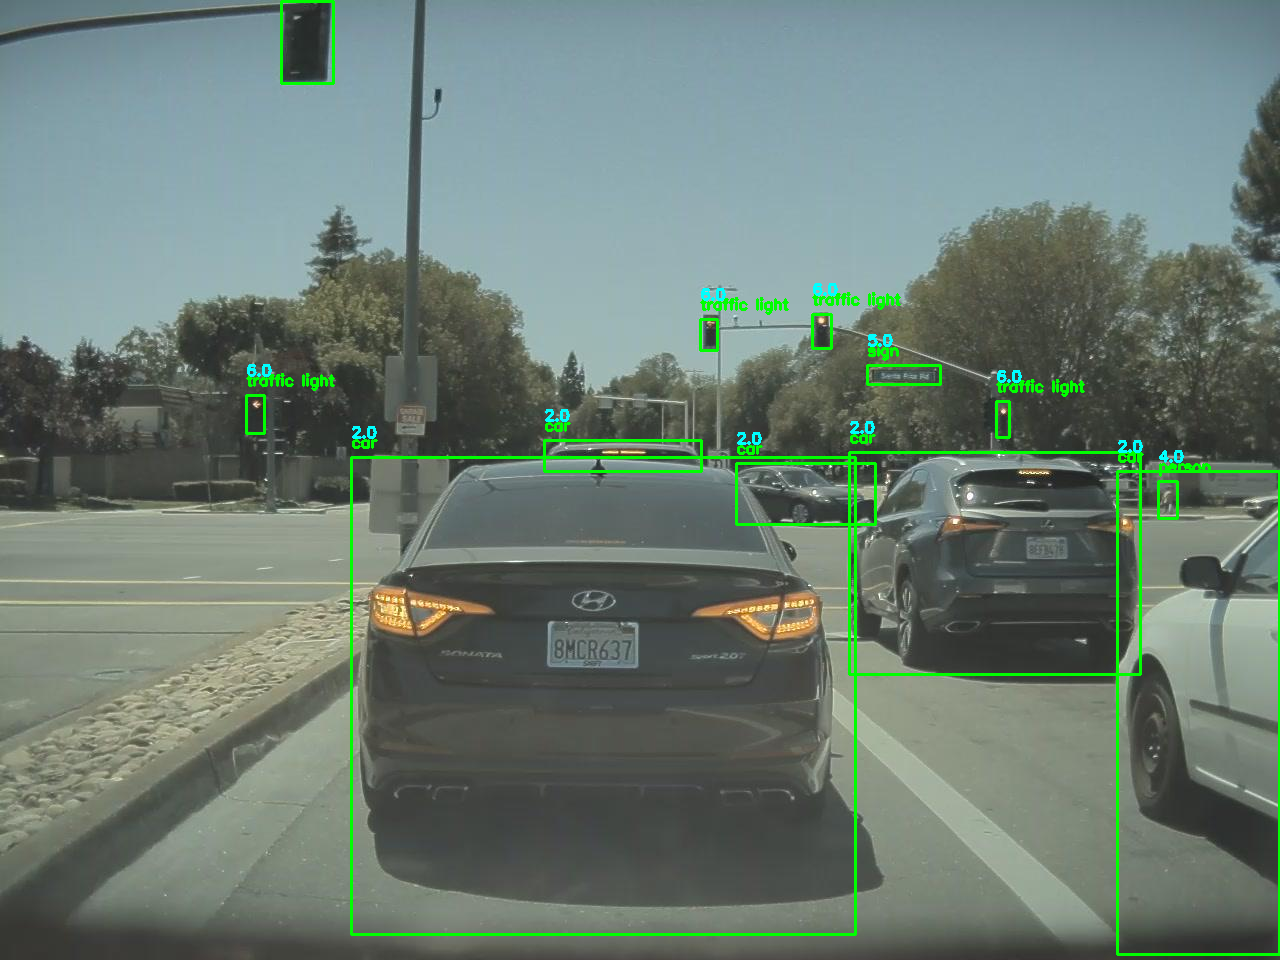

Some classes are missing in the test dataset.


In [28]:
import cv2
from google.colab.patches import cv2_imshow
import os
import yaml

# Load class names from data.yaml
with open('/content/drive/MyDrive/szakdoga/dashcamdatav1yoloformat/data.yaml', 'r') as file:
    data = yaml.safe_load(file)
    class_names = data['names']

# Function to draw bounding boxes and class names on image
def draw_labels(image_path, label_path, class_names):
    image = cv2.imread(image_path)

    with open(label_path, 'r') as file:
        for line in file.readlines():
            class_id, x_center, y_center, width, height = map(float, line.split())

            x_center *= image.shape[1]
            y_center *= image.shape[0]
            width *= image.shape[1]
            height *= image.shape[0]

            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)

            cv2.rectangle(image, (x_min, y_min), (x_min + int(width), y_min + int(height)), (0, 255, 0), 2)
            cv2.putText(image, class_names[int(class_id)], (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(image, str(class_id), (x_min, y_min - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

    cv2_imshow(image)

# Paths
image_dir = '/content/drive/MyDrive/szakdoga/dashcamdatav1yoloformat/test/images'
label_dir = '/content/drive/MyDrive/szakdoga/dashcamdatav1yoloformat/test/labels'

# Find at least one image for each class
found_classes = set()
for image_name in os.listdir(image_dir):
    if image_name.endswith('.jpg'):
        label_name = image_name.replace('.jpg', '.txt')
        image_path = os.path.join(image_dir, image_name)
        label_path = os.path.join(label_dir, label_name)

        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file.readlines():
                    class_id = int(line.split()[0])
                    if class_id not in found_classes:
                        found_classes.add(class_id)
                        draw_labels(image_path, label_path, class_names)
                        if len(found_classes) == len(class_names):
                            break
    if len(found_classes) == len(class_names):
        break

if len(found_classes) != len(class_names):
    print("Some classes are missing in the test dataset.")


## Bounding Box Labeling
Draw bounding boxes and class names on images, and correct class labels.

In [29]:
def extract_class_encodings(matched_pairs):
    true_class_encodings = set()
    pred_class_encodings = set()

    for pair in matched_pairs:
        true_class_encodings.add(pair[0]['class'])
        pred_class_encodings.add(pair[1]['class'])

    return list(true_class_encodings), list(pred_class_encodings)

# Example usage
true_class_encodings, pred_class_encodings = extract_class_encodings(matched_pairs)
print(f"True class encodings: {true_class_encodings}")
print(f"Predicted class encodings: {pred_class_encodings}")

def correct_class_labels(matched_pairs, label_mapping):
    corrected_pairs = []

    for pair in matched_pairs:
        true_box, pred_box = pair

        # Correct predicted class if mapping exists
        pred_box['class'] = label_mapping.get(pred_box['class'], pred_box['class'])
        corrected_pairs.append((true_box, pred_box))

    return corrected_pairs


True class encodings: [0, 1, 2, 3, 4, 5, 6, 7, -1]
Predicted class encodings: [0, 1, 2, 3, 4, 5, 37, 7, 9, 10, 11, 13, 20, -1]


In [30]:
def find_most_likely_mappings(matched_pairs):
    mapping_frequency = {}

    # Count frequency of matches
    for pair in matched_pairs:
        true_class = pair[0]['class']
        pred_class = pair[1]['class']
        if pred_class not in mapping_frequency:
            mapping_frequency[pred_class] = {}
        if true_class not in mapping_frequency[pred_class]:
            mapping_frequency[pred_class][true_class] = 0
        mapping_frequency[pred_class][true_class] += 1

    # Determine most likely mappings and frequencies
    most_likely_mapping = {}
    for pred_class, true_class_freq in mapping_frequency.items():
        most_likely_true_class = max(true_class_freq, key=true_class_freq.get)
        most_likely_mapping[pred_class] = (most_likely_true_class, true_class_freq[most_likely_true_class])

    return most_likely_mapping, mapping_frequency

# Example usage
most_likely_mapping, mapping_frequency = find_most_likely_mappings(matched_pairs)
print("Heuristic Mapping with Frequencies:")
for pred_class, (true_class, freq) in most_likely_mapping.items():
    print(f"Predicted Class {pred_class} -> True Class {true_class}, Frequency: {freq}")


Heuristic Mapping with Frequencies:
Predicted Class 9 -> True Class 6, Frequency: 239
Predicted Class -1 -> True Class 5, Frequency: 391
Predicted Class 2 -> True Class 2, Frequency: 628
Predicted Class 7 -> True Class 7, Frequency: 77
Predicted Class 0 -> True Class 4, Frequency: 27
Predicted Class 5 -> True Class 7, Frequency: 3
Predicted Class 1 -> True Class 0, Frequency: 1
Predicted Class 3 -> True Class 3, Frequency: 3
Predicted Class 11 -> True Class 5, Frequency: 7
Predicted Class 13 -> True Class -1, Frequency: 1
Predicted Class 37 -> True Class -1, Frequency: 1
Predicted Class 20 -> True Class -1, Frequency: 1
Predicted Class 10 -> True Class -1, Frequency: 2
Predicted Class 4 -> True Class -1, Frequency: 1


In [31]:
# Heuristic Mapping (Just for Visualization and Checking)
most_likely_mapping, mapping_frequency = find_most_likely_mappings(matched_pairs)
print("Heuristic Mapping with Frequencies:")
for pred_class, (true_class, freq) in most_likely_mapping.items():
    print(f"Predicted Class {pred_class} -> True Class {true_class}, Frequency: {freq}")

# Manual Mapping (Actual Correction)
manual_mapping = {
    # Your mappings here
    9: 6,
    5: 2,
    0: 4,
    1: 0,
    11: 5
    # Add more mappings as needed
}

# Apply Manual Mappings
corrected_matched_pairs = correct_class_labels(matched_pairs, manual_mapping) # matched_pairs, {k: v[0] for k, v in most_likely_mapping.items()}

# Print to verify
print("\nCorrected Matched Pairs:")
for pair in corrected_matched_pairs:
    print(pair)




Heuristic Mapping with Frequencies:
Predicted Class 9 -> True Class 6, Frequency: 239
Predicted Class -1 -> True Class 5, Frequency: 391
Predicted Class 2 -> True Class 2, Frequency: 628
Predicted Class 7 -> True Class 7, Frequency: 77
Predicted Class 0 -> True Class 4, Frequency: 27
Predicted Class 5 -> True Class 7, Frequency: 3
Predicted Class 1 -> True Class 0, Frequency: 1
Predicted Class 3 -> True Class 3, Frequency: 3
Predicted Class 11 -> True Class 5, Frequency: 7
Predicted Class 13 -> True Class -1, Frequency: 1
Predicted Class 37 -> True Class -1, Frequency: 1
Predicted Class 20 -> True Class -1, Frequency: 1
Predicted Class 10 -> True Class -1, Frequency: 2
Predicted Class 4 -> True Class -1, Frequency: 1

Corrected Matched Pairs:
({'image_id': 0, 'class': 6, 'bbox': [0.15906250476837158, 0.21595832705497742, 0.025648437440395355, 0.06679166853427887], 'bboxID': 0, 'truebox': True}, {'image_id': 0, 'class': 6, 'bbox': [0.15884311497211456, 0.21704667806625366, 0.02310862578

## Class Label Filtering: Refines the dataset by focusing on relevant classes and ensuring label accuracy.

In [32]:
# New function to delete unnecessary classnames
def delete_unnecessary_classnames(corrected_matched_pairs, valid_classes=range(-1,8)):
    """
    Filter out classnames that are not in the range of valid classes (0-7).
    """
    filtered_pairs = []
    for pair in corrected_matched_pairs:
        if pair[1]['class'] in valid_classes:
            #print(pair[0]['class'])
            filtered_pairs.append(pair)
    return filtered_pairs

# ... Rest of your code ...

# After correcting class labels
corrected_matched_pairs = delete_unnecessary_classnames(corrected_matched_pairs)

## Metrics Visualization: Visually represents the model's performance across different classes and the distribution of IoU scores.

In [33]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

# Extract true and predicted labels from matched pairs
true_labels = [pair[0]['class'] for pair in corrected_matched_pairs]
pred_labels = [pair[1]['class'] for pair in corrected_matched_pairs]



# Calculate Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted') # Use average='binary' for binary classification
recall = recall_score(true_labels, pred_labels, average='weighted') # Use average='binary' for binary classification
f1 = f1_score(true_labels, pred_labels, average='weighted') # Use average='binary' for binary classification

# Calculate mean IoU, skipping pairs with placeholders
ious = []
for pair in matched_pairs:
    if pair[0] is not None and pair[1] is not None and pair[0]['bbox'] != [-1, -1, -1, -1] and pair[1]['bbox'] != [-1, -1, -1, -1]:
        iou = calculate_iou(pair[0]['bbox'], pair[1]['bbox'])
        ious.append(iou)

mean_iou = sum(ious) / len(ious) if ious else 0  # avoid division by zero


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Mean IoU: {mean_iou}")


Accuracy: 0.4712589073634204
Precision: 0.6622838461605286
Recall: 0.4712589073634204
F1 Score: 0.4810841996086863
Mean IoU: 0.8473268546895247


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
print(ious)

[0.8725401883161922, 0.6229460961259989, 0.8023439906851738, 0.79644007561696, 0.8047631889038247, 0.8976979619358421, 0.789817312946898, 0.8906589618576463, 0.861631573339088, 0.8772907215988146, 0.8955361820756427, 0.7708501593827043, 0.6771282064662667, 0.7483018948290162, 0.8706086601464258, 0.7786837617053323, 0.8408595121746891, 0.7687942152440911, 0.8792192957607763, 0.869628998880661, 0.8945874979114193, 0.8807412739348881, 0.8988054931842006, 0.7790505733633215, 0.897887706472495, 0.9069976209475424, 0.7415953029060749, 0.949955790188366, 0.5531576043994126, 0.7143188445899685, 0.651677354395839, 0.8573966613075769, 0.6471649264608388, 0.6933827568978285, 0.5955179626201822, 0.7958583440064625, 0.9070309897853868, 0.9014721558096578, 0.8150728183163063, 0.8544200719116738, 0.8723453444005504, 0.8456071068953809, 0.8165256408811633, 0.8498706514921506, 0.9413192755172307, 0.8714911212262955, 0.8960818284068368, 0.9190228342481381, 0.8055756710322934, 0.8783962955761596, 0.84780

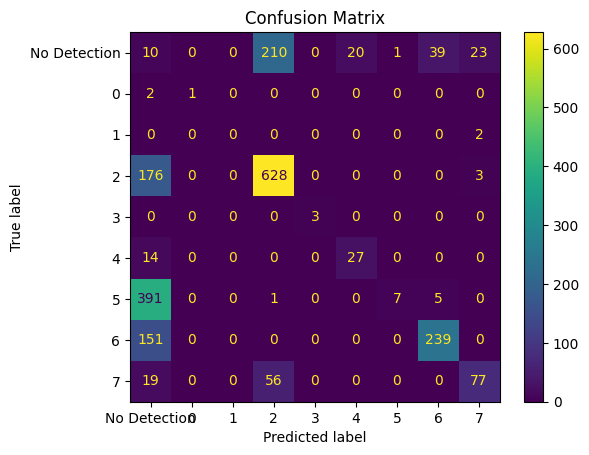

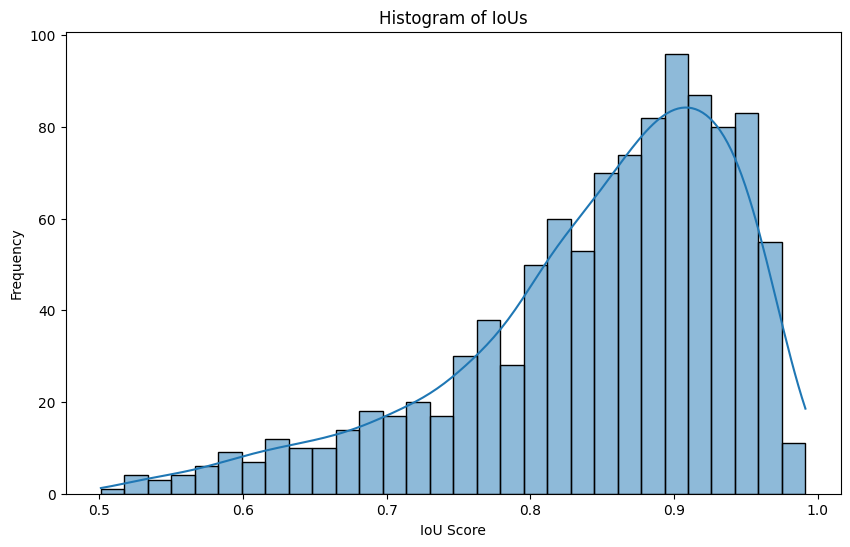

{0, 1, 2, 3, 4, 5, 6, 7, -1}
{0, 2, 3, 4, 5, 6, 7, -1}


In [35]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Extract true labels and predicted labels from matched pairs
true_labels = [pair[0]['class'] if pair[0] is not None else -1 for pair in corrected_matched_pairs]
pred_labels = [pair[1]['class'] if pair[1] is not None else -1 for pair in corrected_matched_pairs]

# Extract the unique classes from true and predicted labels
all_labels = sorted(set(true_labels) | set(pred_labels))

# Create a mapping for labels to indices
label_to_index = {label: index for index, label in enumerate(all_labels)}

# Convert class labels to indices
true_label_indices = [label_to_index[label] for label in true_labels]
pred_label_indices = [label_to_index[label] for label in pred_labels]

# Calculate the confusion matrix using indices
conf_mat = confusion_matrix(true_label_indices, pred_label_indices, labels=range(len(all_labels)))

# Map the indices back to the original class labels for display
display_labels = [str(label) for label in all_labels]
if -1 in all_labels:  # Replace -1 with 'No Detection' for display purposes
    display_labels[all_labels.index(-1)] = 'No Detection'

# Create a ConfusionMatrixDisplay instance with the dynamically created class names
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=display_labels)

# Plot the confusion matrix
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()




# 3. Histogram of IoUs
plt.figure(figsize=(10, 6))
sns.histplot(ious, kde=True, bins=30)
plt.title('Histogram of IoUs')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.show()


print(set(true_labels))
print(set(pred_labels))

## Model Benchmarking: Evaluates the model's performance under different scenarios and datasets.

In [36]:
from ultralytics.utils.benchmarks import benchmark
benchmark(model='yolov5s.pt', data='/content/drive/MyDrive/szakdoga/dashcamdatav1yoloformat/data.yaml', imgsz=640, half=False, device="cpu")

Setup complete ✅ (8 CPUs, 51.0 GB RAM, 28.7/166.8 GB disk)

Benchmarks complete for yolov5su.pt on /content/drive/MyDrive/szakdoga/dashcamdatav1yoloformat/data.yaml at imgsz=640 (625.69s)
                   Format Status❔  Size (MB)  metrics/mAP50-95(B)  Inference time (ms/im)
0                 PyTorch       ✅       17.7               0.1930                  121.74
1             TorchScript       ✅       35.4               0.1925                  116.66
2                    ONNX       ✅       35.1               0.1925                  131.87
3                OpenVINO       ✅       35.2               0.1925                   74.04
4                TensorRT       ❌        0.0                  NaN                     NaN
5                  CoreML       ❎       17.6                  NaN                     NaN
6   TensorFlow SavedModel       ❌        0.0                  NaN                     NaN
7     TensorFlow GraphDef       ❌        0.0                  NaN                     NaN
8 

Format Status❔  Size (MB)  metrics/mAP50-95(B)  Inference time (ms/im)
0                 PyTorch       ✅       17.7               0.1930                  121.74
1             TorchScript       ✅       35.4               0.1925                  116.66
2                    ONNX       ✅       35.1               0.1925                  131.87
3                OpenVINO       ✅       35.2               0.1925                   74.04
4                TensorRT       ❌        0.0                  NaN                     NaN
5                  CoreML       ❎       17.6                  NaN                     NaN
6   TensorFlow SavedModel       ❌        0.0                  NaN                     NaN
7     TensorFlow GraphDef       ❌        0.0                  NaN                     NaN
8         TensorFlow Lite       ❌        0.0                  NaN                     NaN
9     TensorFlow Edge TPU       ❌        0.0                  NaN                     NaN
10          TensorFlow.js       ❌        0.0                  NaN                     NaN
11           PaddlePaddle       ✅       70.1               0.1925                  647.88
12                   ncnn       ✅       35.1               0.1925                  131.95